# Processing your Eclipse Photo with SunPy

Requirements
* Python 3
* matplotlib
* scipy
* sunpy >= 0.8
* skimage
* exifread
* piexif
* astropy

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from matplotlib.patches import Circle
import piexif
import sunpy
import sunpy.map
from datetime import datetime
from skimage.transform import hough_circle, hough_circle_peaks
import astropy.wcs
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord
import sunpy.coordinates
import exifread
%matplotlib inline

/Users/ireland/anaconda/lib/python3.6/site-packages/glymur/config.py:104: UserWarning: The openjp2 library at /Users/ireland/anaconda/lib/libopenjp2.2.1.2.dylib could not be loaded.
  warnings.warn(msg, UserWarning)
/Users/ireland/anaconda/lib/python3.6/site-packages/glymur/config.py:154: UserWarning: Neither the openjp2 nor the openjpeg library could be loaded.  
  warnings.warn(msg)


In [2]:
sunpy.system_info()

 SunPy Installation Information


###########
 General
###########
Time : Wednesday, 16. August 2017 08:25PM UT
System : Darwin
Processor : i386
Arch : 64bit
SunPy : 0.8.dev8694
SunPy_git : 39fe875a35553d3baa35d2e026f096b66180fc2b
OS: Mac OS X 10.12.6 (i386)


###########
 Required Libraries 
###########
Python: 3.6.2
NumPy: 1.12.1
SciPy: 0.19.1
matplotlib: 2.0.2
Astropy: 2.0.1
Pandas: 0.20.3


###########
 Recommended Libraries 
###########
beautifulsoup: 4.5.3
PyQt: NOT INSTALLED
SUDS: 0.6
Sqlalchemy: 1.1.11
Requests: 2.18.3


Replace the following with your photo filename

In [3]:
f = '../sample-photos/total_solar_eclipse.jpg'
exif_f = '../sample-photos/Sun_with_one_AR.jpg'

## First let's try to get some metadata from the file

In [4]:
tags = exifread.process_file(open(exif_f, 'rb'))

In [5]:
tags

{'EXIF ApertureValue': (0x9202) Ratio=2744161/500000 @ 688,
 'EXIF BodySerialNumber': (0xA431) ASCII=042021018255 @ 736,
 'EXIF ColorSpace': (0xA001) Short=sRGB @ 484,
 'EXIF CustomRendered': (0xA401) Short=Normal @ 532,
 'EXIF DateTimeDigitized': (0x9004) ASCII=2017:07:15 14:44:00 @ 660,
 'EXIF DateTimeOriginal': (0x9003) ASCII=2017:07:15 14:44:00 @ 640,
 'EXIF ExifVersion': (0x9000) Undefined=0230 @ 340,
 'EXIF ExposureBiasValue': (0x9204) Signed Ratio=0 @ 696,
 'EXIF ExposureMode': (0xA402) Short=Manual Exposure @ 544,
 'EXIF ExposureProgram': (0x8822) Short=Manual @ 292,
 'EXIF ExposureTime': (0x829A) Ratio=1/250 @ 624,
 'EXIF FNumber': (0x829D) Ratio=67/10 @ 632,
 'EXIF Flash': (0x9209) Short=Flash did not fire, compulsory flash mode @ 436,
 'EXIF FocalLength': (0x920A) Ratio=400 @ 712,
 'EXIF FocalPlaneResolutionUnit': (0xA210) Short=3 @ 520,
 'EXIF FocalPlaneXResolution': (0xA20E) Ratio=5021939/2048 @ 720,
 'EXIF FocalPlaneYResolution': (0xA20F) Ratio=5021939/2048 @ 728,
 'EXIF 

In [6]:
def _convert_to_degress(value):
    """
    Helper function to convert the GPS coordinates stored in the EXIF to degress in float format
    :param value:
    :type value: exifread.utils.Ratio
    :rtype: float
    """
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)

    return d + (m / 60.0) + (s / 3600.0)
    
def get_exif_location(exif_data):
    """
    Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)
    """
    lat = None
    lon = None

    gps_latitude = exif_data.get('GPS GPSLatitude', None)
    gps_latitude_ref = exif_data.get('GPS GPSLatitudeRef', None)
    gps_longitude = exif_data.get('GPS GPSLongitude', None)
    gps_longitude_ref = exif_data.get('GPS GPSLongitudeRef', None)

    if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
        lat = _convert_to_degress(gps_latitude)
        if gps_latitude_ref.values[0] != 'N':
            lat = 0 - lat

        lon = _convert_to_degress(gps_longitude)
        if gps_longitude_ref.values[0] != 'E':
            lon = 0 - lon

    return lat, lon

In [7]:
exif_dict = piexif.load(exif_f)
if "EXIF ExposureTime" in tags:
    exposure_tag = tags['EXIF ExposureTime']
    exposure_time = exposure_tag.values[0].num / exposure_tag.values[0].den * u.s
    print("Exposure time of {0} found!".format(exposure_time))
if "Image Artist" in tags:
    author_str = tags['Image Artist'].values
    print("Author name of {0} found!".format(author_str))
if "Image DateTime" in tags:
    datetime_str = tags['Image DateTime'].values.replace(' ', ':').split(':')
    time = datetime(int(datetime_str[0]), int(datetime_str[1]), 
                    int(datetime_str[2]), int(datetime_str[3]),
                    int(datetime_str[4]), int(datetime_str[5]))
    print("Image time of {0} found!".format(str(time)))
if "Image Model" in tags:
    camera_model_str = tags['Image Model'].values
    print("Camera model of {0} found!".format(camera_model_str))
lat, lon = get_exif_location(exif_dict)
if ((lat != None) and (lon != None)):
    gps = [lat, lon] * u.deg
    print("Found GPS location of {0}, {1} found!".format(gps[0], gps[1]))

Exposure time of 0.004 s found!
Author name of Steven D. Christe found!
Image time of 2017-07-16 08:34:09 found!
Camera model of Canon EOS 70D found!


The following variables need to be defined. If they were not found in the EXIF data please define them below

In [8]:
# exposure_time = 0.1 * u.s
# camera_model_str = 'Canon 70D'
# author_str = 'Julius Berkowski'
time = datetime(2017, 8, 21, 17, 25, 0)
gps = [44.37197, -116.87393] * u.deg

## Read in the image data

In [46]:
# read in the image
im_rgb = matplotlib.image.imread(f)
# remove color info
im = np.average(im_rgb, axis=2)

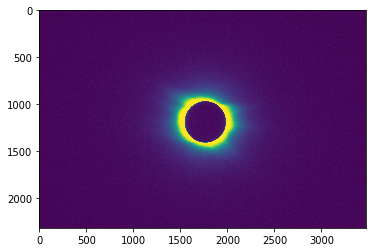

In [11]:
plt.imshow(im)

# Get info from the image

We need the following information from the image
* the location of the center of the Sun/Moon and 
* the scale of the picture which we get from the size of the Sun/Moon in pixels

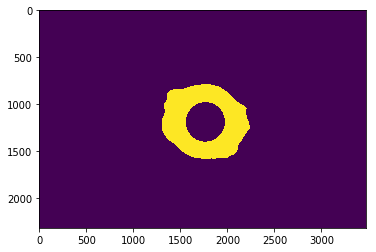

In [12]:
blur_im = ndimage.gaussian_filter(im, 8)
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)

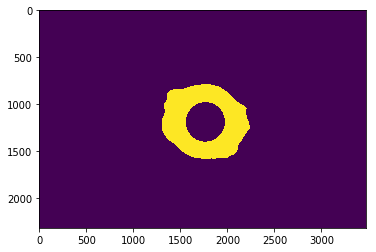

In [13]:
label_im, nb_labels = ndimage.label(mask)
plt.imshow(label_im)

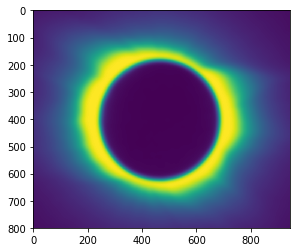

In [14]:
slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
roi = blur_im[slice_x, slice_y]
plt.imshow(roi)

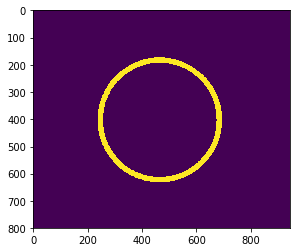

In [15]:
sx = ndimage.sobel(roi, axis=0, mode='constant')
sy = ndimage.sobel(roi, axis=1, mode='constant')
sob = np.hypot(sx, sy)
plt.imshow(sob > (sob.mean() * 5))

In [16]:
from skimage.transform import hough_circle, hough_circle_peaks

hough_radii = np.arange(np.floor(np.mean(sob.shape)/4), np.ceil(np.mean(sob.shape)/2), 1)
hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

# Select the most prominent 5 circles
accums, cy, cx, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
print(cx, cy, radii)

[402] [465] [ 221.]


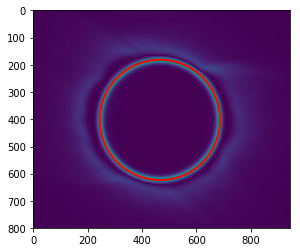

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(sob)
ax.add_patch(circ)
plt.show()

Now let's check it with the original image

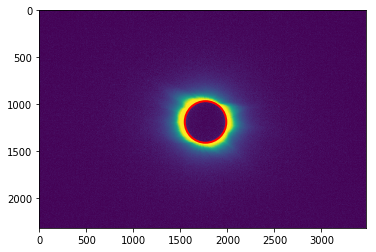

In [18]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
im_cx = (cx + slice_x.start) * u.pix
im_cy = (cy + slice_y.start) * u.pix
im_radius = radii * u.pix
circ = Circle([im_cy.value, im_cx.value], radius=im_radius.value, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(im)
ax.add_patch(circ)
plt.show()

### Let's now put it all into a function (ignore)

In [19]:
def find_sun_center_and_scale(im):
    # first blur the image slightly to smooth it
    blur_im = ndimage.gaussian_filter(im, 8)
    mask = blur_im > blur_im.mean() * 3
    
    # label the image to find the region where the Sun is
    label_im, nb_labels = ndimage.label(mask)
    slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
    roi = blur_im[slice_x, slice_y]

    # take the derivative to find the edge of the Sun/Moon
    sx = ndimage.sobel(roi, axis=0, mode='constant')
    sy = ndimage.sobel(roi, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    
    # finally fit a circle to it
    hough_radii = np.arange(np.floor(np.mean(sob.shape)/4), np.ceil(np.mean(sob.shape)/2), 1)
    hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

    # Select the most prominent 5 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
    
    return cx, cy, radii[0]

In [20]:
cx, cy, radius = find_sun_center_and_scale(im)

# Getting information about the Sun

Let's now get the distance between the Earth and the Sun at the time the photo was taken

In [21]:
dsun = sunpy.coordinates.get_sunearth_distance(time.isoformat())
print(dsun)

1.0115469050609307 AU


The size of the Sun in the sky is then

In [22]:
rsun_obs = np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec')
print(rsun_obs)

948.0096698593347 arcsec


The image plate scale is then

In [23]:
plate_scale = rsun_obs / im_radius
print(plate_scale)

[ 4.28963652] arcsec / pix


We also need the solar rotation angle

In [24]:
loc = EarthLocation(lat=gps[0], lon=gps[1])
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time)

In [25]:
hgln_obs = 0 * u.deg # sunpy.coordinates.get_sun_L0(time)
hglt_obs = sunpy.coordinates.get_sun_B0(time)
print("{0} {1}".format(hglt_obs, hgln_obs))

6.928100471806319 deg 0.0 deg


# Define your WCS object and header

In [26]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crpix = [im_cy[0].value, im_cx[0].value]
w.wcs.cdelt = np.ones(2) * plate_scale.to('arcsec/pix').value
w.wcs.crval = [0, 0]
w.wcs.ctype = ['TAN', 'TAN']
w.wcs.cunit = ['arcsec', 'arcsec']
w.wcs.dateobs = time.isoformat()

Using this object we can now create the sunpy map header

In [27]:
header = dict(w.to_header())
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
header.update({'DSUN_OBS': dsun.to('m').value})
header.update({'HGLN_OBS': hgln_obs.to('deg').value})
header.update({'HGLT_OBS': hglt_obs.to('deg').value})
header.update({'CTYPE1': 'HPLN-TAN'})
header.update({'CTYPE2': 'HPLT-TAN'})
header.update({'RSUN': dsun.to('m').value})
header.update({'RSUN_OBS': np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec').value})

Now add metadata about the photograph.

In [28]:
header.update({'AUTHOR': author_str})
header.update({'EXPTIME': exposure_time.to('s').value})
header.update({'TELESCOP': camera_model_str})
header.update({'INSTRUME': camera_model_str})
header.update({'DETECTOR': camera_model_str})

In [29]:
header

{'AUTHOR': 'Steven D. Christe',
 'CDELT1': 4.2896365152006,
 'CDELT2': 4.2896365152006,
 'CROTA2': -55.04262398060624,
 'CRPIX1': 1767.0,
 'CRPIX2': 1187.0,
 'CRVAL1': 0.0,
 'CRVAL2': 0.0,
 'CTYPE1': 'HPLN-TAN',
 'CTYPE2': 'HPLT-TAN',
 'CUNIT1': 'arcsec',
 'CUNIT2': 'arcsec',
 'DATE-OBS': '2017-08-21T17:25:00',
 'DETECTOR': 'Canon EOS 70D',
 'DSUN_OBS': 151325263110.29028,
 'EXPTIME': 0.004,
 'HGLN_OBS': 0.0,
 'HGLT_OBS': 6.928100471806319,
 'INSTRUME': 'Canon EOS 70D',
 'LATPOLE': 90.0,
 'RSUN': 151325263110.29028,
 'RSUN_OBS': 948.0096698593347,
 'TELESCOP': 'Canon EOS 70D',
 'WCSAXES': 2}

# Creating SunPy Map

(2314, 3474)

In [47]:
m = sunpy.map.Map((im, header))
m

SunPy Map
---------
Observatory:		 Canon EOS 70D
Instrument:		 Canon EOS 70D
Detector:		 Canon EOS 70D
Measurement:		 0.0
Wavelength:		 0.0
Observation Date:	 2017-08-21 17:25:00
Exposure Time:		 0.004000 s
Dimension:		 [ 3474.  2314.] pix
Coordinate System:	 helioprojective
Scale:			 [ 4.28963652  4.28963652] arcsec / pix
Reference Pixel:	 [ 1767.  1187.] pix
Reference Coord:	 [ 0.  0.] arcsec

array([[ 4.        ,  4.        ,  3.        , ...,  4.        ,
         1.66666667,  1.66666667],
       [ 4.        ,  4.        ,  3.        , ...,  1.66666667,
         4.        ,  4.        ],
       [ 4.        ,  3.        ,  3.        , ...,  2.66666667,
         4.66666667,  4.66666667],
       ..., 
       [ 4.66666667,  3.        ,  3.33333333, ...,  3.        ,
         4.        ,  4.        ],
       [ 4.        ,  2.33333333,  1.33333333, ...,  5.        ,
         5.        ,  5.        ],
       [ 4.33333333,  2.33333333,  1.66666667, ...,  5.        ,
         5.        ,  5

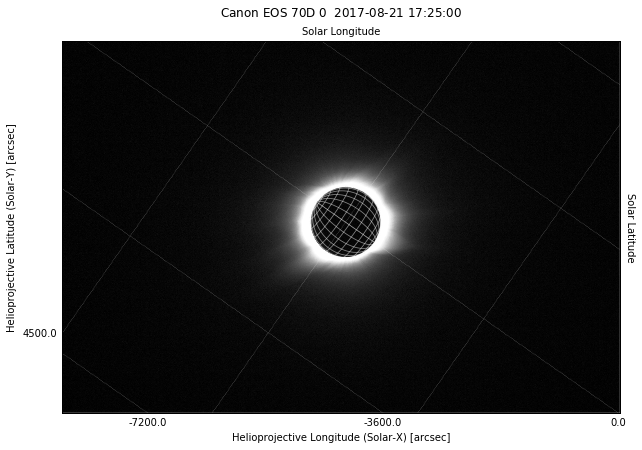

In [49]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.show()

# Overplot the location of Regulus

In [50]:
regulus = SkyCoord(ra='10h08m22.311s', dec='11d58m01.95s', distance=79.3 * u.lightyear, frame='icrs').transform_to(m.coordinate_frame)

In [51]:
regulus

<SkyCoord (Helioprojective: obstime=2017-08-21 17:25:00, rsun=695508000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21 17:25:00): (lon, lat, radius) in (deg, deg, m)
    ( 0.,  6.92810047,   1.51325263e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-4483.3686498,  1509.88537507,   7.50236078e+14)>

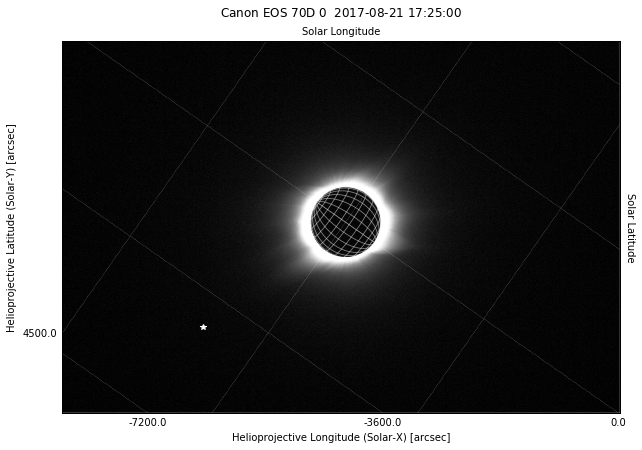

In [52]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, '*w')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.show()

# Plot an SDO Image of the Sun on your photo

In [53]:
# Flag the area that is the eclipsed disk of the Sun.  This area will be flagged as transparent
imy = np.arange(-im_cx.value, im.shape[0]-im_cx.value)
imx = np.arange(-im_cy.value, im.shape[1]-im_cy.value)
xx, yy = np.meshgrid(imx, imy)
r = np.sqrt(xx ** 2 + yy ** 2)
im_min = im.min()
im[r < radius] = im_min-1
m2 = sunpy.map.Map((im, header))

from sunpy.net import Fido, attrs as a
# Replace the time below with the time in UT of the eclipse at your location 
t = a.Time('2017-08-01 17:25:00', "2017-08-01 17:26:00")
aia_result = Fido.search(t, a.Instrument('AIA'), a.Wavelength(171*u.Angstrom))
files = Fido.fetch(aia_result)

[                                        ==================================

/Users/ireland/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


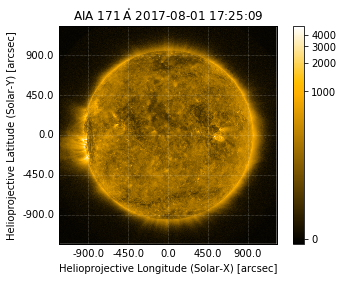

In [54]:
aia_map = sunpy.map.Map(files[0])
aia_map.peek()

In [55]:
# rotate the map so that solar north of AIA and the eclipse image are pointed in the same direction
aia_map2 = aia_map.rotate(-m.meta['crota2']* u.deg)

/Users/ireland/anaconda/lib/python3.6/site-packages/sunpy-0.8.dev8694-py3.6-macosx-10.9-x86_64.egg/sunpy/image/transform.py:122: RuntimeWarning: Input data has been cast to float64
  warnings.warn("Input data has been cast to float64", RuntimeWarning)


/Users/ireland/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


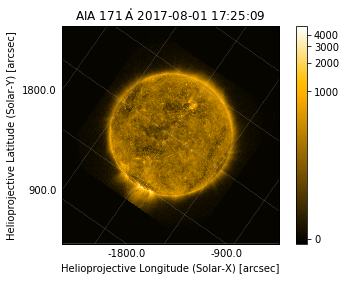

In [56]:
aia_map2.peek()

In [59]:
# Change the color table so that the disk of the Sun is transparent
import matplotlib.cm as cm
from astropy.visualization import LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
m_cm = cm.gray
m_cm.set_under(color='r', alpha=0.0)
m_norm = ImageNormalize(vmin=im_min, vmax=im.max(), stretch=LinearStretch())
m2.plot_settings['cmap'] = m_cm
m2.plot_settings['norm'] = m_norm

# Create a composite map
cmap = sunpy.map.Map(aia_map2, m2, composite=True)

/Users/ireland/anaconda/lib/python3.6/site-packages/sunpy-0.8.dev8694-py3.6-macosx-10.9-x86_64.egg/sunpy/map/compositemap.py:418: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  "extent": list(m.xrange.value) + list(m.yrange.value),


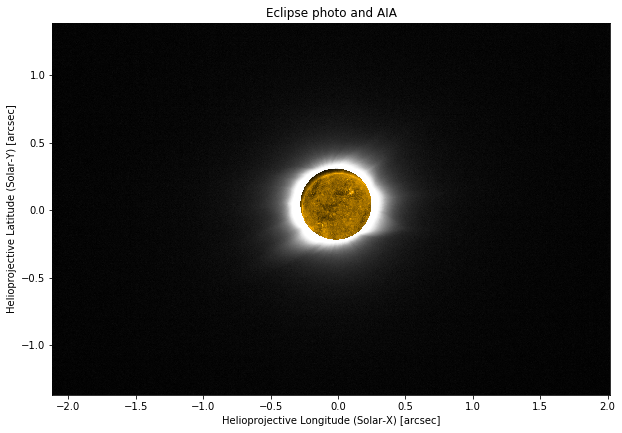

In [60]:
figure = plt.figure(figsize=(10,10))
axes = figure.add_subplot(111)
ret = cmap.plot(axes=axes, title="Eclipse photo and AIA")